# Age classification analysis

## Table of Contents
    
    
<div class="alert alert-block alert-info" style="margin-top: 20px">
    
* [I. Introduction](#0)<br>
    * [1.1. The challenge](#1)<br>
    * [1.2. The dataset](#2)<br>
    * [1.3. The classifiers](#3)<br>

* [II. Data loading and pre-processing](#4)<br>
    * [2.1. Generating datasets](#5)<br>
    * [2.2. Class decomposition](#6)<br>
    
* [III. Machine Learning algorithms](#7)<br>
    * [3.1. Support Vector Classification](#8)<br>
        * [3.1.1. Original dataset](#9)<br>
        * [3.1.2. Sobel dataset](#10)<br>
        * [3.1.3. Contrast dataset](#11)<br>
        * [3.1.4. HoG dataset](#12)<br>
        * [3.1.5. Decomposed dataset](#13)<br>
        * [3.1.6. Section analysis](#14)<br>

    * [3.2. Convolutional Neural Network](#15)<br>
        * [3.2.1. Original dataset](#16)<br>
        * [3.2.2. Sobel dataset](#17)<br>
        * [3.2.3. Contrast dataset](#18)<br>
        * [3.2.4. Section analysis](#19)<br>
    
* [IV. Discussion](#20)<br>
* [V. References](#21)<br>

</div>

In [86]:
# File loading
import os

# Image pre-processing and datasets generation
from skimage import color, exposure, feature
from skimage.filters import sobel
from skimage.transform import resize
from sklearn.cluster import KMeans
import math
from keras.utils import np_utils

# Plotting
import matplotlib.pyplot as plt

# Image operations
import cv2
import pandas as pd
import numpy as np

# Classification models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing, svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Flatten, Dense, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

## I. Introduction<a id="0"></a>

### 1.1. The challenge<a id="1"></a>

Anyone who has ever used a self-checkout in the UK to purchase an age restricted item such as alcohol or RedBull is aware that these purchases require manual age verification by staff, namely you must be over 25.

Since early 2020 when masks became commonplace there is an additional issue that supermarket staff have to deal with: how can they tell if someone is over or under 25 with a mask on? The author is no stranger to the stare, take a step back, squint (sometimes even being asked to pull the mask down) and final approval of the purchase.

But what if the self-checkout could do that on its own?

ASDA has recently been introducing new machines at its checkouts that film you as you are scanning your items through. The image you see is passport-like and determined what type of images the dataset would need to contain.

The models in this notebook will perform a multi-class classification between four classes, namely:
* mask_over25
* mask_under25
* noMask_over25
* noMask_under25

### 1.2. The dataset<a id="2"></a>

The added complexity of the analysis, namely age differentiation, was the main driving factor behind choosing a dataset. The author was looking for portrait style images which would be the closest format to what a self-checkout machine would see.

The original dataset found consists of 20,000 images and can be found on Kaggle at: https://www.kaggle.com/prasoonkottarathil/face-mask-lite-dataset?select=with_mask.

The dataset used in this analysis consists of 1,000 images extracted from the Kaggle dataset and split into the abovementioned four classes each containing 250 images. It is important to mention these images were generated using a Generative Adversial Network and the masks were superimposed. Although this is not ideal it does provide the format and uniformity the author was looking for.

The images' size is 1024 X 1024 and color. They will be loaded as grayscale, resized to 100 x 100, and the following additional operations performed:
* sobel filter for edge detection
* contrast enhancement using adaptive equalization for skin patterns detection
* Histogram of Gradients (HOG) feature extraction, and
* forced class decomposition.

Below is an illustration of the images contained and filters applied to generate additional datasets.

The image shape is: (1024, 1024)


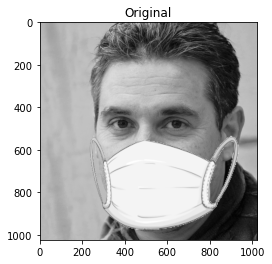

In [2]:
# loading example image from local storage as grayscale
example = cv2.imread('example.png', 0)

# plotting image
plt.imshow(example, cmap='Greys_r')
plt.title('Original')

# printing image size
print('The image shape is:', example.shape)

Text(0.5, 1.0, 'Resized AH Contrast')

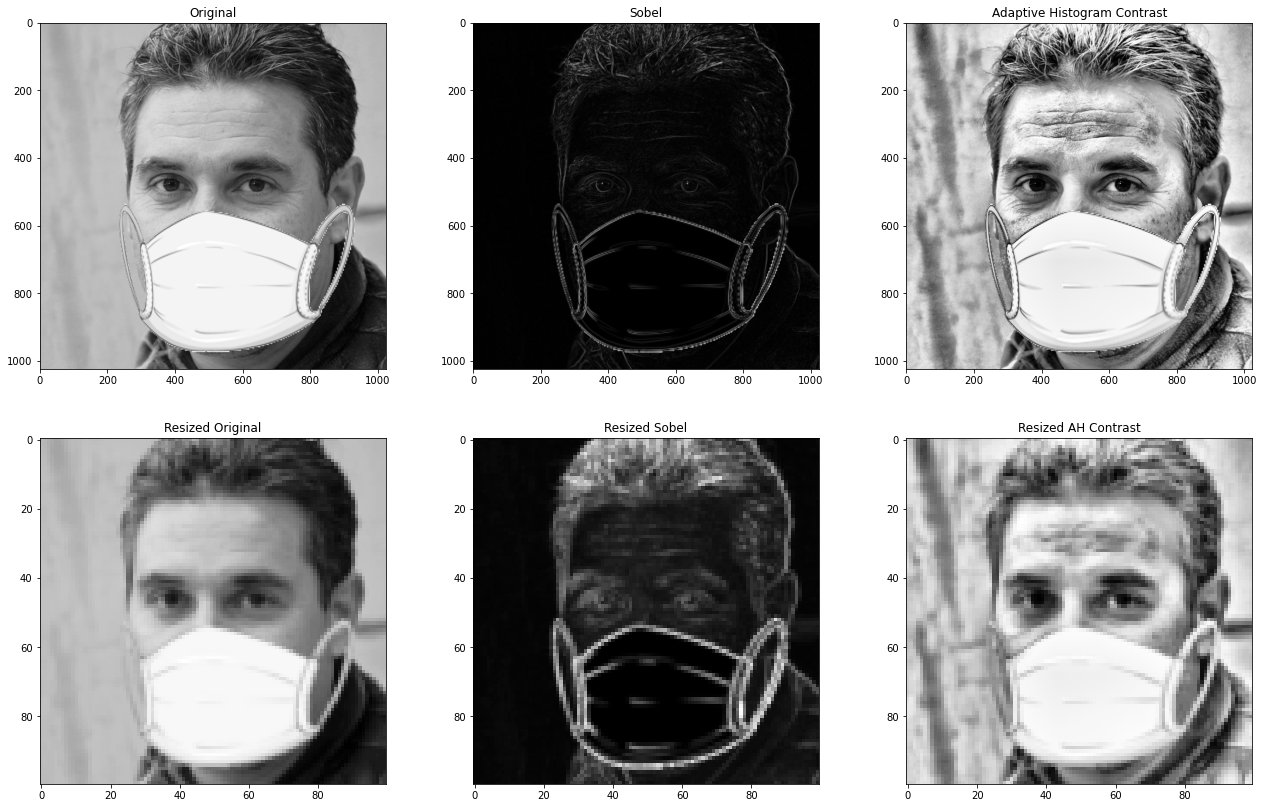

In [177]:
# Applying Sobel for edge detection
sobel_im =sobel(example)

# Applying contrast enhancement using adaptive equalization with a clip limit of 0.03
# Please note: the higher the clip value the higher the contrast
contrast_im = exposure.equalize_adapthist(example, clip_limit=0.03)

# setting size values
height = 100
width = 100

# resizing images
resized_orig = resize(example, (height, width))
sobel_res = resize(sobel_im, (height, width))
contrast_res = resize(contrast_im, (height, width))

# setting figure plot
fig, ax = plt.subplots(2,3, figsize=(22, 14))

ax[0,0].imshow(example, cmap='Greys_r');
ax[0,0].set_title('Original')
ax[0,1].imshow(sobel_im, cmap='Greys_r');
ax[0,1].set_title('Sobel')
ax[0,2].imshow(contrast_im, cmap='Greys_r');
ax[0,2].set_title('Adaptive Histogram Contrast')
ax[1,0].imshow(resized_orig, cmap='Greys_r');
ax[1,0].set_title('Resized Original')
ax[1,1].imshow(sobel_res, cmap='Greys_r');
ax[1,1].set_title('Resized Sobel')
ax[1,2].imshow(contrast_res, cmap='Greys_r');
ax[1,2].set_title('Resized AH Contrast')

These images will then be further pre-processed as explained in the Data Processing section and fed to the machine learning algorithms.

### 1.3. The classifiers<a id="3"></a>

For the purpose of this exercise we will use a Support Vector Classifier and a Convolutional Neural Network. Full justifications can be found in their respective sections.

## II. Data loading and pre-processing<a id="4"></a>

### 2.1. Generating datasets<a id="5"></a>

In [5]:
# defining HOG prior to loading loop
# Reference: this code was provided in the Advanced Data Science lecture, 17th February 2021(Moreno, 2021).

class HOG:
    def __init__(self, orientations = 9, pixelsPerCell = (8, 8),
        cellsPerBlock = (3, 3), transform = False):
        self.orienations = orientations
        self.pixelsPerCell = pixelsPerCell
        self.cellsPerBlock = cellsPerBlock
        self.transform = transform

    def describe(self, image):
        # compute HOG for the image
        hist = feature.hog(image, orientations = self.orienations,
            pixels_per_cell = self.pixelsPerCell,
            cells_per_block = self.cellsPerBlock,
            transform_sqrt = self.transform)
        ## return the HOG features
        return hist
    
hog = HOG(orientations = 18, pixelsPerCell = (10, 10), cellsPerBlock = (1, 1), transform = True)

In [6]:
# setting size values
height = 100
width = 100

# path value
path = 'dataset'

# creating lists for required datasets
images2D = [] # list containing images as 2D numpy arrays
original_dataset = [] # list for flattened pixels
target_class =  [] # list of target class

sobel_dataset = [] # for sobel images as 2D numpy arrays
flat_sobel = [] # for sobel flattened pixels

contrast_dataset = [] # for contrasted images as 2D numpy arrays
flat_contrast = [] # for adaptive equalization flatten pixels

hog_dataset = [] # for extracted HOG features


# importing images and applying pre-processing and feature extractions
for root, dirs, files in os.walk(path):
     for file in files:
        with open(os.path.join(root, file), "r") as auto:
            img = cv2.imread(root+'/'+file, 0)
            
            # Resizing images
            img = cv2.resize(img, (width, height)) 
            images2D.append(img)
            
            # Appending flattened images to the flattened pixels list
            original_dataset.append(img.flatten())
            
            # Applying Sobel to original resized image and appending datasets
            sobel_im = sobel(img)
            sobel_dataset.append(sobel_im)
            flat_sobel.append(sobel_im.flatten())
            
            # Applying contrast enhancement using adaptive equalization with a clip limit of 0.03 to original resized images
            # Please note: the higher the clip value the higher the contrast
            contrast_im = exposure.equalize_adapthist(img, clip_limit=0.03)
            contrast_dataset.append(contrast_im)
            flat_contrast.append(contrast_im.flatten())
            
            # Extracting HOG features from the original resized images and appending the list
            hog_feat = hog.describe(img)
            hog_dataset.append(hog_feat)
            
            # Appending the class list
            target_class.append(root.replace(path,'').replace('\\','')) 

print("Data loaded")

Data loaded


In [178]:
# converting all datasets to numpy arrays
images2D = np.array(images2D)
original_dataset = np.array(original_dataset)
target_class = np.array(target_class)

sobel_dataset = np.array(sobel_dataset)
flat_sobel =np.array(flat_sobel)

contrast_dataset = np.array(contrast_dataset)
flat_contrast = np.array(flat_contrast)

hog_dataset = np.array(hog_dataset)

# printing sizes
print('The size of the flattened datasets is:', original_dataset.shape)
print('The size of the other datasets is:', images2D.shape)
print('The size of the HOG dataset is:', hog_dataset.shape)

The size of the flattened datasets is: (1000, 10000)
The size of the other datasets is: (1000, 100, 100)
The size of the HOG dataset is: (1000, 1800)


In [179]:
# creating a numpy array containing numeric values for each class
list_values = pd.factorize(target_class)[0].tolist()
target_labels = np.array(list_values)

# sanity check
target_labels.shape

(1000,)

The original, flattened dataset will contain pixel values with 10,000 features and balanced classes.

In [7]:
# converting original dataset to pandas dataframe for presentation
presentRepo = pd.DataFrame(original_dataset)
presentRepo['class'] = pd.DataFrame(target_class)
presentRepo.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,class
0,137,135,135,135,137,138,139,140,138,137,...,73,81,68,95,114,102,94,105,115,mask_over25
1,244,243,242,242,241,242,241,241,239,241,...,232,232,233,233,233,232,232,232,235,mask_over25
2,46,44,47,49,49,50,52,54,54,55,...,211,60,66,71,77,40,34,35,33,mask_over25
3,127,117,110,97,94,100,119,136,146,151,...,51,56,54,90,113,113,104,113,98,mask_over25
4,51,54,55,54,55,56,61,61,62,61,...,83,86,88,86,87,86,84,82,85,mask_over25


Text(0, 0.5, 'Count')

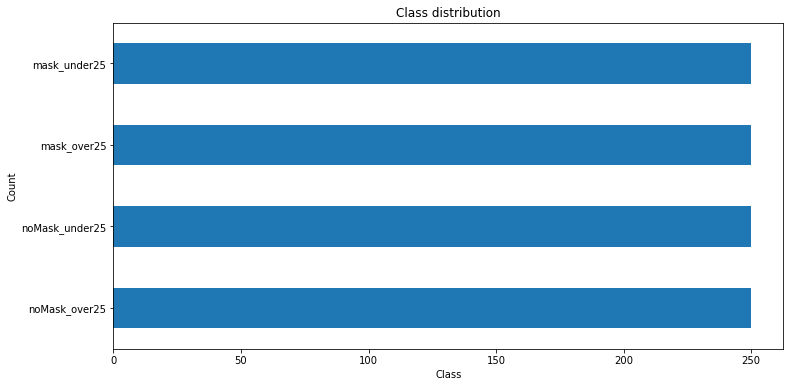

In [9]:
# plotting class distribution
ax = presentRepo['class'].value_counts().plot(kind='barh', figsize=(12,6), title="Class distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

The sobel datasets will contain an array of floats forming a Sobel edge map (Skimage.filters.sobel, 2021).

In [51]:
# showing first 5 arrays
print(flat_sobel[0:5])

[[0.00784314 0.00808452 0.00219222 ... 0.03720327 0.06673151 0.03175321]
 [0.00392157 0.00620054 0.00294118 ... 0.00098039 0.00746644 0.00903877]
 [0.00277297 0.00490196 0.01447532 ... 0.01117819 0.00138648 0.00713736]
 [0.02849891 0.04649375 0.05176619 ... 0.00887783 0.0285831  0.04123479]
 [0.00620054 0.009249   0.00310027 ... 0.00970539 0.00310027 0.00765711]]


The contrast datasets will contain an array of floats forming a 'normalised' version of the image (Skimage.exposure.equalize_adapthist, 2021).

In [52]:
# showing first 5 arrays
print(flat_contrast[0:5])

[[0.71914342 0.66298445 0.66298445 ... 0.35577635 0.41890891 0.45143175]
 [1.         1.         1.         ... 0.93492876 0.94794301 0.98112626]
 [0.12555337 0.10458682 0.15352927 ... 0.14461387 0.18033694 0.13207083]
 [0.54542102 0.3846343  0.32870313 ... 0.77559926 0.87701291 0.71063307]
 [0.11854402 0.18150516 0.20948106 ... 0.56578947 0.51088293 0.58152976]]


In [50]:
# showing first 5 arrays
print(hog_dataset[0:5])

[[0.29661774 0.29661774 0.29661774 ... 0.30965372 0.30965372 0.14706261]
 [0.46800508 0.         0.10612386 ... 0.2134116  0.         0.        ]
 [0.33661141 0.33661141 0.33661141 ... 0.42071907 0.37338811 0.09771363]
 [0.6264732  0.28863681 0.         ... 0.06585391 0.27148128 0.19450437]
 [0.32235046 0.05399388 0.         ... 0.22999769 0.20457153 0.08216399]]


### 2.2. Class decomposition<a id="6"></a>

We will use the existing ***presentRepo*** dataframe which contains the original, flattened pixels and classes, convert classes to integer values, decompose them and return a new decomposed dataset and labels. The last code block maps the classes.

In [32]:
# replacing class strings with int values
presentRepo['class'].replace({'mask_over25':0, 'mask_under25':1, 'noMask_over25': 2, 'noMask_under25':3}, inplace=True)

# converting dataset to numpy array
presentRepo = np.array(presentRepo)

In [61]:
np.random.seed(123)

# setting values of classes
class_distribution=[250,250,250,250]
Avg = sum(class_distribution)/len(class_distribution)


# running Carlos' method for class decomposition
for i,c in enumerate(class_distribution):
    X = presentRepo[np.where(presentRepo[:,-1]==i)][:,:10000] 
    y = np.zeros((c,1))+i
    
    # calculate number of clusters
    nclusters = math.floor((c/Avg)+1)    
    print('Clusters to decompose class '+str(i)+':', nclusters)
    
    if nclusters>1:
        kmeans = KMeans(n_clusters=nclusters).fit(X)
        
        ## add to the last column decimals for the new class
        for j,n in enumerate(X):
            y[j]=y[j]+(kmeans.labels_[j]/10) # divide by 10 so that it gets added as decimal
        
    if i==0: # If this is the first time, copy the first class into a new repo
        decomp_dataset = np.concatenate((X,y),axis=1).copy()
        
    else: # stack the new into the existing
        decomp_dataset = np.vstack((decomp_dataset,np.concatenate((X,y),axis=1)))

print()
print('Decomposed dataset sample')
print(decomp_dataset)

Clusters to decompose class 0: 2
Clusters to decompose class 1: 2
Clusters to decompose class 2: 2
Clusters to decompose class 3: 2

Decomposed dataset sample
[[1.37e+02 1.35e+02 1.35e+02 ... 1.05e+02 1.15e+02 0.00e+00]
 [2.44e+02 2.43e+02 2.42e+02 ... 2.32e+02 2.35e+02 0.00e+00]
 [4.60e+01 4.40e+01 4.70e+01 ... 3.50e+01 3.30e+01 1.00e-01]
 ...
 [1.04e+02 1.15e+02 1.18e+02 ... 1.36e+02 1.20e+02 3.10e+00]
 [1.04e+02 1.05e+02 1.05e+02 ... 1.02e+02 1.09e+02 3.00e+00]
 [1.85e+02 1.85e+02 1.84e+02 ... 3.60e+01 3.00e+01 3.10e+00]]


Text(0, 0.5, 'Count')

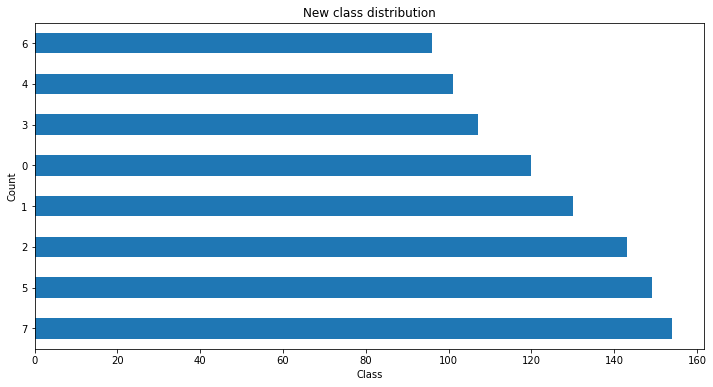

In [62]:
# creating array containing new classes
new_labels = decomp_dataset[:,10000]

# array containing numeric values for each class
list_values2 = pd.factorize(new_labels)[0].tolist()
decomp_labels = np.array(list_values2)

# removing labels from decomp_dataset
decomp_dataset = np.delete(decomp_dataset, -1, axis=1)

# to pandas df for plotting
new_labels_df = pd.DataFrame(decomp_labels)

# plotting new class distribution
ax = new_labels_df.iloc[:,0].value_counts().plot(kind='barh', figsize=(12,6), title="New class distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

In [44]:
# mapping classes
# creating dictionary contianing classes
dict_ = {'Original Class' : ['mask_over25', 'mask_under25', 'noMask_over25', 'noMask_under25'], 
         'Factorised Class': [0,1,2,3 ], 
         'Decomposed Class': [(0,1),(2,3),(4,5),(6,7)]}

# to dataframe
class_map = pd.DataFrame.from_dict(dict_)
class_map.set_index('Original Class', inplace=True)

# show
class_map

,Factorised Class,Decomposed Class
Original Class,,
mask_over25,0,"(0, 1)"
mask_under25,1,"(2, 3)"
noMask_over25,2,"(4, 5)"
noMask_under25,3,"(6, 7)"


## III. Machine Learning Algorithms<a id="7"></a>

### 3.1. Support Vector Classification<a id="8"></a>

The svm.SVC classifier uses a one-vs-one methodology where, essentially, a binary classifier is computed for each class pair. Although this is computationally more expensive, the model learns to distinguish each class from one another instead of a class from all other classes (SVM Mathematical Formulation, 2021).

**The methodology:**

* Train/test split of 70/30
* class labels stratified to ensure equal representation of classes
* train and test features scaled
* GridSearchCV from a grid of parameters
* Displaying the top 10 best parameters, and
* classification report to obtain prediction scores for each class.

**GridSearchCV**
Performs a brut force search of the best parameters from a given grid of values and implements a fit and score method. Although computationally more expensive it undertakes a combination of every parameter (Sklearn.model_selection.GridSearchCV, 2021).

    Model scoring
We will use ***recall_weighted*** as an internal scoring metric for the model to assess its ability of identifying the number of instances for each class. For each class it calculates the metric and finds their average using the number of true instances (Sklearn.metrics.recall_score, 2021).

    Cross-validation strategy
Assigning  ***cv=5*** tells the model to use a StratifiedKFold approach which will preserve the class distribution (Sklearn.model_selection.StratifiedKFold, 2021).

At the end of this sub-section all results are compiled and discussed.

In [ ]:
# assigining general range of parameters
parameters = [{'kernel':['rbf'], 'gamma': [1,0.1,0.01,0.001], 'C': [1,10,100,1000]},
              {'kernel':['linear'], 'C':[1,10,100,1000]},
              {'kernel':['poly'], 'gamma': [1,0.1,0.01,0.001], 'C': [1,10,100,1000], 'degree': [2,3,4]}]

#### 3.1.1. Original dataset<a id="9"></a>

In [53]:
# setting seed for reproducibility
np.random.seed(123)

# splitting dataset
X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(original_dataset, target_labels, 
                                                                    stratify= target_labels, test_size=0.3)

# scaling training features
scaler_train_org = preprocessing.StandardScaler().fit(X_train_org)
x_train_org_scaled = scaler_train_org.transform(X_train_org)

# scaling test features
scaler_test_org = preprocessing.StandardScaler().fit(X_test_org)
x_test_org_scaled = scaler_test_org.transform(X_test_org)

In [55]:
# setting seed for reproducibility
np.random.seed(123)

# applying GridSearchCV
model_svm_org1 = GridSearchCV(svm.SVC(), param_grid = parameters, scoring = 'recall_weighted', cv=5)

# fitting model
model_svm_org_fitted1 = model_svm_org1.fit(x_train_org_scaled, y_train_org)

# putting training results in a pandas dataframe for presentation and analysis by mean test score
results_svm_org1 = pd.DataFrame(model_svm_org_fitted1.cv_results_)
results_svm_org1 = results_svm_org1.sort_values(by=['mean_test_score'], ascending=False)
results_svm_org1 = results_svm_org1[['params', 'rank_test_score', 'mean_fit_time', 'mean_test_score']]

# printing results
print("The best parameters for this model are:", model_svm_org_fitted1.best_params_)
print()
print("The best score on the training set is:", "%.3f" % round(model_svm_org_fitted1.best_score_, 3))
print()
print("Top 10 best parameters on the training set")
print()
results_svm_org1.head(10)

The best parameters for this model are: {'C': 1, 'kernel': 'linear'}

The best score on the training set is: 0.846

Top 10 best parameters on the training set



,params,rank_test_score,mean_fit_time,mean_test_score
19,"{'C': 1000, 'kernel': 'linear'}",1,1.877840,0.845714
18,"{'C': 100, 'kernel': 'linear'}",1,1.894321,0.845714
17,"{'C': 10, 'kernel': 'linear'}",1,1.918242,0.845714
16,"{'C': 1, 'kernel': 'linear'}",1,1.890264,0.845714
48,"{'C': 100, 'degree': 3, 'gamma': 1, 'kernel': ...",5,3.306889,0.775714
26,"{'C': 1, 'degree': 3, 'gamma': 0.01, 'kernel':...",5,3.348026,0.775714
24,"{'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'p...",5,3.288413,0.775714
27,"{'C': 1, 'degree': 3, 'gamma': 0.001, 'kernel'...",5,3.299053,0.775714
51,"{'C': 100, 'degree': 3, 'gamma': 0.001, 'kerne...",5,3.307163,0.775714
50,"{'C': 100, 'degree': 3, 'gamma': 0.01, 'kernel...",5,3.291445,0.775714


The discrepancy between the linear and poly kernel scores is wide enough to determine that a linear model would work best on the original dataset.

In [56]:
# predicting targets
y_pred_org1 = model_svm_org_fitted1.predict(x_test_org_scaled)

print("Metrics on test set")
print()
print(classification_report(y_test_org, y_pred_org1))

Metrics on test set

              precision    recall  f1-score   support

           0       0.75      0.73      0.74        75
           1       0.74      0.76      0.75        75
           2       0.86      0.80      0.83        75
           3       0.81      0.87      0.84        75

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300



#### 3.1.2. Sobel dataset<a id="10"></a>

In [59]:
# setting seed for reproducibility
np.random.seed(123)

# scaling training features
scaler_train_sob = preprocessing.StandardScaler().fit(X_train_sob)
x_train_sob_scaled = scaler_train_sob.transform(X_train_sob)

# scaling test features
scaler_test_sob = preprocessing.StandardScaler().fit(X_test_sob)
x_test_sob_scaled = scaler_test_sob.transform(X_test_sob)

In [60]:
# setting seed for reproducibility
np.random.seed(123)


# applying GridSearchCV
model_svm_sob3 = GridSearchCV(svm.SVC(), param_grid = parameters, scoring = 'recall_weighted', cv=5)

# fitting model
model_svm_sob_scaled = model_svm_sob3.fit(x_train_sob_scaled, y_train_sob)

# putting results in a dataframe for presentation and analysis
results_svm_sob_scaled = pd.DataFrame(model_svm_sob_scaled.cv_results_)
results_svm_sob_scaled = results_svm_sob_scaled.sort_values(by=['mean_test_score'], ascending=False)
results_svm_sob_scaled = results_svm_sob_scaled[['params', 'rank_test_score', 'mean_fit_time', 'mean_test_score']]


# printing results
print("The best parameters for this model are:", model_svm_sob_scaled.best_params_)
print()
print("The best score on the training set is:", "%.3f" % round(model_svm_sob_scaled.best_score_, 3))
print()
print("Top 10 best parameters on the training set")
print()
results_svm_sob_scaled.head(10)

The best parameters for this model are: {'C': 1, 'kernel': 'linear'}

The best score on the training set is: 0.834

Top 10 best parameters on the training set



,params,rank_test_score,mean_fit_time,mean_test_score
19,"{'C': 1000, 'kernel': 'linear'}",1,2.544841,0.834286
18,"{'C': 100, 'kernel': 'linear'}",1,2.537331,0.834286
17,"{'C': 10, 'kernel': 'linear'}",1,2.548263,0.834286
16,"{'C': 1, 'kernel': 'linear'}",1,2.566319,0.834286
48,"{'C': 100, 'degree': 3, 'gamma': 1, 'kernel': ...",5,4.584615,0.634286
26,"{'C': 1, 'degree': 3, 'gamma': 0.01, 'kernel':...",5,4.390494,0.634286
24,"{'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'p...",5,4.386855,0.634286
27,"{'C': 1, 'degree': 3, 'gamma': 0.001, 'kernel'...",5,4.416899,0.634286
51,"{'C': 100, 'degree': 3, 'gamma': 0.001, 'kerne...",5,4.573314,0.634286
50,"{'C': 100, 'degree': 3, 'gamma': 0.01, 'kernel...",5,4.579064,0.634286


Same as with the original dataset - linear kernel outperforms on the sobel dataset.

In [63]:
# running model on test set
y_pred_sob3 = model_svm_sob_scaled.predict(x_test_sob_scaled)

# checking other metrics
print("Metrics on test set")
print()
print(classification_report(y_test_sob, y_pred_sob3))

Metrics on test set

              precision    recall  f1-score   support

           0       0.85      0.80      0.82        75
           1       0.81      0.85      0.83        75
           2       0.83      0.80      0.82        75
           3       0.81      0.84      0.82        75

    accuracy                           0.82       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.82      0.82      0.82       300



#### 3.1.3. Contrast dataset<a id="11"></a>

In [65]:
# setting seed for reproducibility
np.random.seed(123)

# splitting dataset
X_train_cont, X_test_cont, y_train_cont, y_test_cont = train_test_split(flat_contrast, target_labels, 
                                                                        stratify = target_labels, test_size=0.3)

# scaling training features
scaler_train_cont = preprocessing.StandardScaler().fit(X_train_cont)
x_train_cont_scaled = scaler_train_cont.transform(X_train_cont)

# scaling test features
scaler_test_cont = preprocessing.StandardScaler().fit(X_test_cont)
x_test_cont_scaled = scaler_test_cont.transform(X_test_cont)

In [66]:
# setting seed for reproducibility
np.random.seed(123)

# applying GridSearchCV
model_svm_cont = GridSearchCV(svm.SVC(), param_grid = parameters, scoring = 'recall_weighted', cv=5)

# fitting model
model_svm_cont_scaled = model_svm_cont.fit(x_train_cont_scaled, y_train_cont)

# results to dataframe
results_svm_cont_scaled = pd.DataFrame(model_svm_cont_scaled.cv_results_)
results_svm_cont_scaled = results_svm_cont_scaled.sort_values(by=['mean_test_score'], ascending=False)
results_svm_cont_scaled = results_svm_cont_scaled[['params', 'rank_test_score', 'mean_fit_time', 'mean_test_score']]


# printing results
print("The best parameters for this model are:", model_svm_cont_scaled.best_params_)
print()
print("The best score on the training set is:", "%.3f" % round(model_svm_cont_scaled.best_score_, 3))
print()
print("Top 10 best parameters on the training set")
print()
results_svm_cont_scaled.head(10)

The best parameters for this model are: {'C': 1, 'kernel': 'linear'}

The best score on the training set is: 0.819

Top 10 best parameters on the training set



,params,rank_test_score,mean_fit_time,mean_test_score
19,"{'C': 1000, 'kernel': 'linear'}",1,2.591137,0.818571
18,"{'C': 100, 'kernel': 'linear'}",1,2.557228,0.818571
17,"{'C': 10, 'kernel': 'linear'}",1,2.509064,0.818571
16,"{'C': 1, 'kernel': 'linear'}",1,2.579806,0.818571
48,"{'C': 100, 'degree': 3, 'gamma': 1, 'kernel': ...",5,4.357506,0.740000
26,"{'C': 1, 'degree': 3, 'gamma': 0.01, 'kernel':...",5,4.635452,0.740000
24,"{'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'p...",5,4.627430,0.740000
27,"{'C': 1, 'degree': 3, 'gamma': 0.001, 'kernel'...",5,4.721696,0.740000
51,"{'C': 100, 'degree': 3, 'gamma': 0.001, 'kerne...",5,4.441015,0.740000
50,"{'C': 100, 'degree': 3, 'gamma': 0.01, 'kernel...",5,4.363487,0.740000


In [67]:
# checking other metrics
y_pred_cont = model_svm_cont_scaled.predict(x_test_cont_scaled)

# checking other metrics
print("Metrics on test set")
print()
print(classification_report(y_test_cont, y_pred_cont))

Metrics on test set

              precision    recall  f1-score   support

           0       0.79      0.75      0.77        75
           1       0.76      0.80      0.78        75
           2       0.85      0.85      0.85        75
           3       0.85      0.85      0.85        75

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



#### 3.1.4 HOG dataset<a id="12"></a>

In [68]:
# setting seed for reproducibility
np.random.seed(123)

# splitting dataset
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(hog_dataset, target_labels, 
                                                                    stratify = target_labels, test_size=0.3)

# scaling training features
scaler_train_hog = preprocessing.StandardScaler().fit(X_train_hog)
x_train_hog_scaled = scaler_train_hog.transform(X_train_hog)

# scaling test features
scaler_test_hog = preprocessing.StandardScaler().fit(X_test_hog)
x_test_hog_scaled = scaler_test_hog.transform(X_test_hog)

In [69]:
# setting seed for reproducibility
np.random.seed(123)

# applying GridSearchCV
model_svm_hog = GridSearchCV(svm.SVC(), param_grid = parameters, scoring = 'recall_weighted', cv=5)

# fitting model
model_svm_hog_scaled = model_svm_hog.fit(x_train_hog_scaled, y_train_hog)

# results to dataframe
results_svm_hog_scaled = pd.DataFrame(model_svm_hog_scaled.cv_results_)
results_svm_hog_scaled = results_svm_hog_scaled.sort_values(by=['mean_test_score'], ascending=False)
results_svm_hog_scaled = results_svm_hog_scaled[['params', 'rank_test_score', 'mean_fit_time', 'mean_test_score']]


# printing results
print("The best parameters for this model are:", model_svm_hog_scaled.best_params_)
print()
print("The best score on the training set is:", "%.3f" % round(model_svm_hog_scaled.best_score_, 3))
print()
print("Top 10 best parameters on the training set")
print()
results_svm_hog_scaled.head(10)

The best parameters for this model are: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

The best score on the training set is: 0.810

Top 10 best parameters on the training set



,params,rank_test_score,mean_fit_time,mean_test_score
11,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",1,0.758347,0.810000
15,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",1,0.732507,0.810000
7,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",1,0.750584,0.810000
3,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",4,0.750708,0.808571
18,"{'C': 100, 'kernel': 'linear'}",5,0.543166,0.791429
17,"{'C': 10, 'kernel': 'linear'}",5,0.542453,0.791429
16,"{'C': 1, 'kernel': 'linear'}",5,0.548696,0.791429
19,"{'C': 1000, 'kernel': 'linear'}",5,0.540268,0.791429
20,"{'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'p...",9,0.723249,0.552857
21,"{'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': ...",9,0.727156,0.552857


Although the rbf kernel models scored higher the difference between them and the linear kernel is small enough to consider using it for the hog dataset.

In [71]:
# checking other metrics
y_pred_hog = model_svm_hog_scaled.predict(x_test_hog_scaled)

# checking other metrics
print("Metrics on test set")
print()
print(classification_report(y_test_hog, y_pred_hog))

Metrics on test set

              precision    recall  f1-score   support

           0       0.78      0.76      0.77        75
           1       0.77      0.79      0.78        75
           2       0.83      0.80      0.82        75
           3       0.81      0.84      0.82        75

    accuracy                           0.80       300
   macro avg       0.80      0.80      0.80       300
weighted avg       0.80      0.80      0.80       300



#### 3.1.5. Decomposed dataset<a id="13"></a>

In [72]:
# setting seed for reproducibility
np.random.seed(123)

# splitting dataset
X_train_decomp, X_test_decomp, y_train_decomp, y_test_decomp = train_test_split(decomp_dataset, decomp_labels, 
                                                                                stratify = decomp_labels, test_size=0.3)

# scaling training features
scaler_train_decomp = preprocessing.StandardScaler().fit(X_train_decomp)
x_train_decomp_scaled = scaler_train_decomp.transform(X_train_decomp)

# scaling test features
scaler_test_decomp = preprocessing.StandardScaler().fit(X_test_decomp)
x_test_decomp_scaled = scaler_test_decomp.transform(X_test_decomp)

In [73]:
# setting seed for reproducibility
np.random.seed(123)

# applying GridSearchCV
model_svm_decomp = GridSearchCV(svm.SVC(), param_grid = parameters, scoring = 'recall_weighted', cv=5)

# fitting model
model_svm_decomp_fitted = model_svm_decomp.fit(x_train_decomp_scaled, y_train_decomp)


results_svm_decomp = pd.DataFrame(model_svm_decomp_fitted.cv_results_)
results_svm_decomp = results_svm_decomp.sort_values(by=['mean_test_score'], ascending=False)
results_svm_decomp = results_svm_decomp[['params', 'rank_test_score', 'mean_fit_time', 'mean_test_score']]


# printing results
print("The best parameters for this model are:", model_svm_decomp_fitted.best_params_)
print()
print("The best score on the training set is:", "%.3f" % round(model_svm_decomp_fitted.best_score_, 3))
print()
print("Top 10 best parameters on the training set")
print()
results_svm_decomp.head(10)

The best parameters for this model are: {'C': 1, 'kernel': 'linear'}

The best score on the training set is: 0.744

Top 10 best parameters on the training set



,params,rank_test_score,mean_fit_time,mean_test_score
19,"{'C': 1000, 'kernel': 'linear'}",1,1.888775,0.744286
18,"{'C': 100, 'kernel': 'linear'}",1,1.893187,0.744286
17,"{'C': 10, 'kernel': 'linear'}",1,1.900078,0.744286
16,"{'C': 1, 'kernel': 'linear'}",1,1.895433,0.744286
48,"{'C': 100, 'degree': 3, 'gamma': 1, 'kernel': ...",5,4.282750,0.685714
26,"{'C': 1, 'degree': 3, 'gamma': 0.01, 'kernel':...",5,4.325505,0.685714
24,"{'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'p...",5,4.266219,0.685714
27,"{'C': 1, 'degree': 3, 'gamma': 0.001, 'kernel'...",5,4.273842,0.685714
51,"{'C': 100, 'degree': 3, 'gamma': 0.001, 'kerne...",5,4.291462,0.685714
50,"{'C': 100, 'degree': 3, 'gamma': 0.01, 'kernel...",5,4.259496,0.685714


Although least performing as the above models, the linear kernel is better suited.

In [74]:
# checking other metrics
y_pred_decomp = model_svm_decomp_fitted.predict(x_test_decomp_scaled)

# checking other metrics
print("Metrics on test set")
print()
print(classification_report(y_test_decomp, y_pred_decomp))

Metrics on test set

              precision    recall  f1-score   support

           0       0.75      0.67      0.71        36
           1       0.70      0.72      0.71        39
           2       0.65      0.72      0.68        43
           3       0.77      0.72      0.74        32
           4       0.81      0.73      0.77        30
           5       0.74      0.82      0.78        45
           6       0.85      0.59      0.69        29
           7       0.75      0.87      0.81        46

    accuracy                           0.74       300
   macro avg       0.75      0.73      0.74       300
weighted avg       0.75      0.74      0.74       300



In [79]:
# collecting results for analysis

# empty dataframe
models_results = pd.DataFrame(columns=['Model','Mask_over25', 'Mask_under25', 'noMask_over25', 
                                       'noMask_under25', 'Train Score', 'Test Average Score', 'Best parameters'])

# assining model results to lists
org_result = ['model_svm_org', 0.73, 0.76, 0.80, 0.87, 
              "%.3f" % round(model_svm_org_fitted1.best_score_, 3), 0.79, model_svm_org_fitted1.best_params_]
sob_result = ['model_svm_sob', 0.77, 0.83, 0.79, 0.83,  
              "%.3f" % round(model_svm_sob_scaled.best_score_, 3), 0.80, model_svm_sob_scaled.best_params_]
cont_result = ['model_svm_cont', 0.75, 0.80, 0.85, 0.85,  
               "%.3f" % round(model_svm_cont_scaled.best_score_, 3), 0.81, model_svm_cont_scaled.best_params_]
hog_result = ['model_svm_hog', 0.76, 0.79, 0.80, 0.84,  
              "%.3f" % round(model_svm_hog_scaled.best_score_, 3), 0.80, model_svm_hog_scaled.best_params_]
decomp_result = ["model_svm_decomp",(0.67,0.72), (0.72,0.72), (0.73,0.82), (0.59,0.87), 
                 "%.3f" % round(model_svm_decomp_fitted.best_score_, 3), 0.74, model_svm_decomp_fitted.best_params_]

# converting lists to series to append dataframe
org_result = pd.Series(org_result, index=models_results.columns)
sob_result = pd.Series(sob_result, index=models_results.columns)
cont_result = pd.Series(cont_result, index=models_results.columns)
hog_result = pd.Series(hog_result, index=models_results.columns)
decomp_result = pd.Series(decomp_result, index=models_results.columns)

# appending results to dataframe
models_results = models_results.append(org_result,ignore_index=True)
models_results = models_results.append(sob_result,ignore_index=True)
models_results = models_results.append(cont_result,ignore_index=True)
models_results = models_results.append(hog_result,ignore_index=True)
models_results = models_results.append(decomp_result,ignore_index=True)

# view results
models_results.set_index('Model', inplace=True)
models_results

,Mask_over25,Mask_under25,noMask_over25,noMask_under25,Train Score,Test Average Score,Best parameters
Model,,,,,,,
model_svm_org,0.73,0.76,0.8,0.87,0.846,0.79,"{'C': 1, 'kernel': 'linear'}"
model_svm_sob,0.77,0.83,0.79,0.83,0.834,0.80,"{'C': 1, 'kernel': 'linear'}"
model_svm_cont,0.75,0.8,0.85,0.85,0.819,0.81,"{'C': 1, 'kernel': 'linear'}"
model_svm_hog,0.76,0.79,0.8,0.84,0.810,0.80,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}"
model_svm_decomp,"(0.67, 0.72)","(0.72, 0.72)","(0.73, 0.82)","(0.59, 0.87)",0.744,0.74,"{'C': 1, 'kernel': 'linear'}"


#### 3.1.6. Section Analysis<a id="14"></a>

In terms of performance, most models have returned decent results and the train and test scores are close enough to agree the models are well fitted.

All models seem to struggle to correctly classify the ***Mask_over25*** class and perform best on the ***noMask_under25*** class. We can also note the large score difference in the decomposed dataset for this class. This may be due to how the images were split by the author as the latter class contains a higher number of images of teenagers and children whose facial structure is different from each other and from that of adults present in the first class potentially making it easier to distinguish.

Apart from the hog dataset, all models returned high scores using the linear kernel although we have already noted the performance difference on this dataset between linear and rbf was quite small.

### 3.2 Convolutional Neural Network<a id="15"></a>

The datasets used in this section are:
* images2D (original dataset)
* sobel_dataset (unflattened)
* contrast_dataset (unflattened), and
* target_labels to predict.

All three feature sets will be split 80/20 with the target labels stratified, reshaped for the network and normalised.

In [83]:
np.random.seed(123)

## splitting, reshaping, converting to floats and normalising features; converting classes to categorical
# original images
X_train_im2D, X_test_im2D, y_train_im2D, y_test_im2D = train_test_split(images2D, target_labels, 
                                                                        stratify= target_labels, test_size=0.2)

X_train_im2D = X_train_im2D.reshape(X_train_im2D.shape[0], 100, 100, 1)
X_train_im2D = X_train_im2D.astype('float32')
X_train_im2D /= 255 

X_test_im2D = X_test_im2D.reshape(X_test_im2D.shape[0], 100, 100, 1)
X_test_im2D = X_test_im2D.astype('float32')
X_test_im2D /= 255

y_train_im2D = np_utils.to_categorical(y_train_im2D, 4)
y_test_im2D = np_utils.to_categorical(y_test_im2D, 4)


# sobel dataset
X_train_sobset, X_test_sobset, y_train_sobset, y_test_sobset = train_test_split(sobel_dataset, target_labels, 
                                                                                stratify= target_labels, test_size=0.2)

X_train_sobset = X_train_sobset.reshape(X_train_sobset.shape[0], 100, 100, 1)
X_train_sobset = X_train_sobset.astype('float32')
X_train_sobset /= 255 

X_test_sobset = X_test_sobset.reshape(X_test_sobset.shape[0], 100, 100, 1)
X_test_sobset = X_test_sobset.astype('float32')
X_test_sobset /= 255

y_train_sobset = np_utils.to_categorical(y_train_sobset, 4)
y_test_sobset = np_utils.to_categorical(y_test_sobset, 4)


# contrast dataset
X_train_contset, X_test_contset, y_train_contset, y_test_contset = train_test_split(contrast_dataset, target_labels, 
                                                                                    stratify= target_labels, test_size=0.2)

X_train_contset = X_train_contset.reshape(X_train_contset.shape[0], 100, 100, 1)
X_train_contset = X_train_contset.astype('float32')
X_train_contset /= 255

X_test_contset = X_test_contset.reshape(X_test_contset.shape[0], 100, 100, 1)
X_test_contset = X_test_contset.astype('float32')
X_test_contset /= 255

y_train_contset = np_utils.to_categorical(y_train_contset, 4)
y_test_contset = np_utils.to_categorical(y_test_contset, 4)

**The model architecture:**

* Sequential model

* Input layer: 15 kernels with a size of 3 to extract as much information as possible from the images without it being computationally to expensive when passed to the Dense output layer; no padding as we are not gaining any insight from the image outer edges.

* MaxPooling to summarise first layer output with a window size of 2, strides will default to window size and no padding

* Second convolutional layer with 5 kernels with a size of 3 and another MaxPooling layer to summarise second output

* Dropout of 25% to reduce number of parameters

* Output layer with 4 units, one for each class, and softmax activation function to return probability distribution (Softmax function, 2021).

**Compiling:**

* using ***adam*** optimizer as a general first choice and computationally efficient (Adam, 2021)
* ***categorical_crossentropy*** for multi-class classification as the labels are one-hot encoded (CategoricalCrossentropy class, 2021)
* ***accuracy*** as a metric to assess how often predictions match the labels (Accuracy class, 2021).

**Fitting:**
* validation split of 20% to compare training and testing metrics


**The methodology:**

* define and compile the model as described above

* create a KerasClassifier object wrapping the defined model (KerasClassifier, 2021, Brownlee, 2016)

* RandomizedSearchCV for a random search for best parameters as computationally better than GridSearchCV on a CNN - same 5-fold cross-validation strategy as above (RandomizedSearchCV, 2021)

* pass the KerasClassifier and parameters to RandomizedSearchCV

Please note that the parameter search cells took an average 2 hours to run with time discrepancies. For this reason KerasClassifier was not fully implemented and the best parameters were fitted seperately to the model.

In [153]:
# Reference: this code was inspired from Brownlee, 2016 and Esteban, 2021.

# defining model architecture
def model_cnn(learning_rate):
    opt = Adam(lr=learning_rate)
    
    # initialising sequential model
    model_cnn_org = Sequential()
    
    # adding input convolutional layer
    model_cnn_org.add(Conv2D(15, kernel_size=3, activation= 'relu', input_shape=(100,100,1)))
    
    # summarising convolutional layer output
    model_cnn_org.add(MaxPooling2D(pool_size=(2,2)))
    
    # second convolutional and MaxPooling layers
    model_cnn_org.add(Conv2D(5, kernel_size=3, activation= 'relu'))
    model_cnn_org.add(MaxPooling2D(pool_size=(2,2)))
    
    # reducing number of parameters
    model_cnn_org.add(Dropout(0.25))

    # flatten to pass to Dense layer for classification
    model_cnn_org.add(Flatten())

    # output layer
    model_cnn_org.add(Dense(4, activation='softmax'))

    # compiling model
    model_cnn_org.compile(optimizer= opt, loss= 'categorical_crossentropy', metrics=['accuracy'])
    
    return model_cnn_org

# creating KerasClasifier object in order to search for best parameters
model = KerasClassifier(build_fn = model_cnn)

# assining parameter values
cnn_parameters = {'epochs':[5, 10, 50, 100], 'batch_size':[32, 64, 128],'learning_rate':[0.1,0.01,0.001]}

#### 3.2.1. Original dataset<a id="16"></a>

In [ ]:
np.random.seed(123)

# passing KerasClassifier object and parameters for best parameters search
cnn_params_org_search = RandomizedSearchCV(model, param_distributions = cnn_parameters, cv=5,  verbose=0)

# fitting model
org_search_results = cnn_params_org_search.fit(X_train_im2D, y_train_im2D, validation_split=0.2, verbose=0)

In [164]:
# retrieving best score, parameters and top 10 best parameters
results_cnn_org = pd.DataFrame(org_search_results.cv_results_)
results_cnn_org = results_cnn_org.sort_values(by=['mean_test_score'], ascending=False)
results_cnn_org = results_cnn_org[['params', 'rank_test_score', 'mean_fit_time', 'mean_test_score']]

print("Best score:", org_search_results.best_score_)
print()
print("Best parameters:", org_search_results.best_params_)
print()
results_cnn_org.head(10)

Best score: 0.8087499856948852

Best parameters: {'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}



,params,rank_test_score,mean_fit_time,mean_test_score
1,"{'learning_rate': 0.001, 'epochs': 50, 'batch_...",1,60.150172,0.80875
6,"{'learning_rate': 0.001, 'epochs': 100, 'batch...",2,113.017461,0.80125
3,"{'learning_rate': 0.001, 'epochs': 100, 'batch...",3,118.938408,0.79500
5,"{'learning_rate': 0.001, 'epochs': 50, 'batch_...",4,55.565652,0.78375
4,"{'learning_rate': 0.001, 'epochs': 10, 'batch_...",5,12.468269,0.72750
2,"{'learning_rate': 0.01, 'epochs': 5, 'batch_si...",6,6.357194,0.63375
7,"{'learning_rate': 0.01, 'epochs': 50, 'batch_s...",7,55.486958,0.56375
8,"{'learning_rate': 0.1, 'epochs': 5, 'batch_siz...",8,6.280399,0.24000
0,"{'learning_rate': 0.1, 'epochs': 50, 'batch_si...",9,59.236024,0.22500
9,"{'learning_rate': 0.1, 'epochs': 50, 'batch_si...",10,55.755734,0.22125


Although the top 3 best parameters have close scores the fitting time is almost double. We will refit the model with the best ranked, get the summary, plot the loss and accuracy on the training and testing sets and evaluate it.

In [100]:
# refitting with best parameters
opt = Adam(lr=0.001)

# initialising sequential model
model_cnn_org = Sequential()
    
# adding input convolutional layer
model_cnn_org.add(Conv2D(15, kernel_size=3, activation= 'relu', input_shape=(100,100,1)))
    
# summarising convolutional layer output
model_cnn_org.add(MaxPooling2D(pool_size=(2,2)))
    
# second convolutional and MaxPooling layers
model_cnn_org.add(Conv2D(5, kernel_size=3, activation= 'relu'))
model_cnn_org.add(MaxPooling2D(pool_size=(2,2)))
    
# reducing number of parameters
model_cnn_org.add(Dropout(0.25))

# flatten to pass to Dense layer for classification
model_cnn_org.add(Flatten())

# output layer
model_cnn_org.add(Dense(4, activation='softmax'))

# compiling model
model_cnn_org.compile(optimizer= opt, loss= 'categorical_crossentropy', metrics=['accuracy'])

# fitting model with best parameters
model_cnn_org_fitted = model_cnn_org.fit(X_train_im2D, y_train_im2D, validation_split = 0.2, 
                                         epochs = 50, batch_size = 32, verbose = 0)

In [165]:
# getting model summary
model_cnn_org.summary()

Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_222 (Conv2D)          (None, 98, 98, 15)        150       
_________________________________________________________________
max_pooling2d_222 (MaxPoolin (None, 49, 49, 15)        0         
_________________________________________________________________
conv2d_223 (Conv2D)          (None, 47, 47, 5)         680       
_________________________________________________________________
max_pooling2d_223 (MaxPoolin (None, 23, 23, 5)         0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 23, 23, 5)         0         
_________________________________________________________________
flatten_60 (Flatten)         (None, 2645)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 4)              

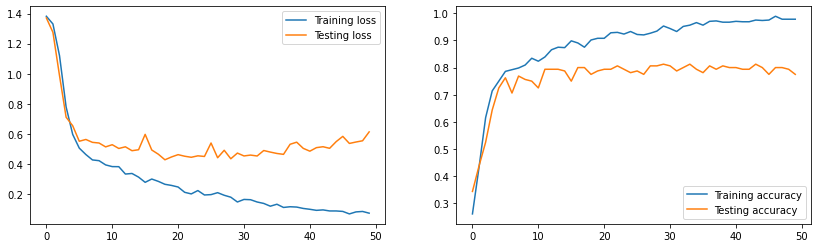

In [145]:
# plotting accuracies and losses
plt.figure(figsize=(14, 4))

# plotting loss
plt.subplot(1, 2, 1)
plt.plot(model_cnn_org_fitted.history['loss'])
plt.plot(model_cnn_org_fitted.history['val_loss'])
plt.legend(['Training loss','Testing loss'])

# plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model_cnn_org_fitted.history['accuracy'])
plt.plot(model_cnn_org_fitted.history['val_accuracy'])
plt.legend(['Training accuracy','Testing accuracy'])

plt.show()

The model starts overfitting after approximately the 6th epoch. The number of parameters passed through the model is reasonable leading the author to contemplate whether the parameters themselves may be leading to the overfitting. We will add a model checkpoint during fitting to monitor the loss and return the best model for evaluation.

In [160]:
# creating checkpoint
checkpoint = ModelCheckpoint('weights_org.hdf5', monitor = 'val_loss', save_best_only = True)
cnn_checkpoint =[checkpoint]

# refitting model
model_cnn_org_refitted = model_cnn_org.fit(X_train_im2D, y_train_im2D, validation_split = 0.2, 
                                           epochs = 50, batch_size = 32, callbacks= cnn_checkpoint, verbose = 0)

In [161]:
# load stored weights
model_cnn_org.load_weights('weights_org.hdf5')

# checking metrics
loss, accuracy = model_cnn_org.evaluate(X_test_im2D, y_test_im2D, verbose=0)
print('Loss: ', loss,'\nAcc: ', accuracy)

Loss:  1.199878215789795 
Acc:  0.7450000047683716


We will repeat this process for the remaining datasets

#### 3.2.2. Sobel dataset<a id="17"></a>

In [ ]:
np.random.seed(123)

cnn_params_sob_search = RandomizedSearchCV(model, param_distributions = cnn_parameters, cv=5,  verbose=0)
sob_search_results = cnn_params_sob_search.fit(X_train_sobset, y_train_sobset, validation_split=0.2, verbose=0)

In [166]:
# retrieving best score, parameters and top 10 best parameters
results_cnn_sob = pd.DataFrame(sob_search_results.cv_results_)
results_cnn_sob = results_cnn_sob.sort_values(by=['mean_test_score'], ascending=False)
results_cnn_sob = results_cnn_sob[['params', 'rank_test_score', 'mean_fit_time', 'mean_test_score']]

print("Best score:", sob_search_results.best_score_)
print()
print("Best parameters:", sob_search_results.best_params_)
print()
results_cnn_sob.head(10)

Best score: 0.6387499988079071

Best parameters: {'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64}



,params,rank_test_score,mean_fit_time,mean_test_score
6,"{'learning_rate': 0.001, 'epochs': 100, 'batch...",1,115.097222,0.63875
3,"{'learning_rate': 0.001, 'epochs': 100, 'batch...",2,117.006327,0.54125
1,"{'learning_rate': 0.001, 'epochs': 50, 'batch_...",3,59.084954,0.41875
5,"{'learning_rate': 0.001, 'epochs': 50, 'batch_...",4,56.461266,0.24250
9,"{'learning_rate': 0.1, 'epochs': 50, 'batch_si...",5,57.345286,0.23250
0,"{'learning_rate': 0.1, 'epochs': 50, 'batch_si...",6,60.341310,0.23125
8,"{'learning_rate': 0.1, 'epochs': 5, 'batch_siz...",7,6.386092,0.22250
2,"{'learning_rate': 0.01, 'epochs': 5, 'batch_si...",8,6.285092,0.21750
4,"{'learning_rate': 0.001, 'epochs': 10, 'batch_...",8,12.492283,0.21750
7,"{'learning_rate': 0.01, 'epochs': 50, 'batch_s...",8,56.762664,0.21750


In [175]:
# refitting with best parameters
opt = Adam(lr=0.001)

# initialising sequential model
model_cnn_sob = Sequential()
    
# adding input convolutional layer
model_cnn_sob.add(Conv2D(15, kernel_size=3, activation= 'relu', input_shape=(100,100,1)))
    
# summarising convolutional layer output
model_cnn_sob.add(MaxPooling2D(pool_size=(2,2)))
    
# second convolutional and MaxPooling layers
model_cnn_sob.add(Conv2D(5, kernel_size=3, activation= 'relu'))
model_cnn_sob.add(MaxPooling2D(pool_size=(2,2)))
    
# reducing number of parameters
model_cnn_sob.add(Dropout(0.25))

# flatten to pass to Dense layer for classification
model_cnn_sob.add(Flatten())

# output layer
model_cnn_sob.add(Dense(4, activation='softmax'))

# compiling model
model_cnn_sob.compile(optimizer= opt, loss= 'categorical_crossentropy', metrics=['accuracy'])

# fitting model with best parameters
model_cnn_sob_fitted = model_cnn_sob.fit(X_train_sobset, y_train_sobset, validation_split = 0.2, 
                                         epochs = 100, batch_size = 64, verbose = 0)

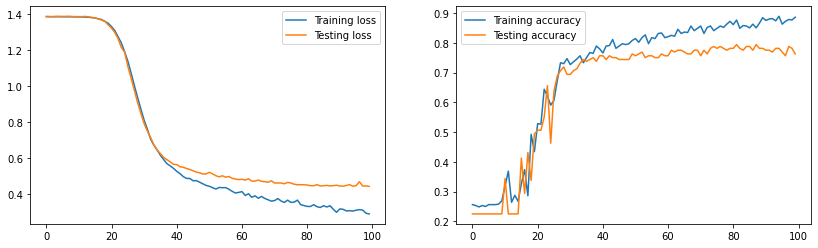

In [147]:
# plotting accuracies and losses
plt.figure(figsize=(14, 4))

# plotting loss
plt.subplot(1, 2, 1)
plt.plot(model_cnn_sob_fitted.history['loss'])
plt.plot(model_cnn_sob_fitted.history['val_loss'])
plt.legend(['Training loss','Testing loss'])

# plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model_cnn_sob_fitted.history['accuracy'])
plt.plot(model_cnn_sob_fitted.history['val_accuracy'])
plt.legend(['Training accuracy','Testing accuracy'])

plt.show()

Although there is less overfitting in this model the learning curves are less stable indicating an issue with either the chosen parameters (including the adam optimizer) or the model architecture itself. Adding a BatchNormalization layer between the two convolutional ones may help stabilize the learning before attempting another parameter search.

In [167]:
# creating checkpoint
checkpoint = ModelCheckpoint('weights_sob.hdf5', monitor = 'val_loss', save_best_only = True)
cnn_checkpoint =[checkpoint]

# refitting model with retained weights
model_cnn_sob_fitted = model_cnn_sob.fit(X_train_sobset, y_train_sobset, validation_split = 0.2, 
                                         epochs = 100, batch_size = 64, callbacks= cnn_checkpoint, verbose = 0)

In [168]:
# load stored weights
model_cnn_sob.load_weights('weights_sob.hdf5')

# checking metrics
loss, accuracy = model_cnn_sob.evaluate(X_test_sobset, y_test_sobset, verbose=0)
print('Loss: ', loss,'\nAcc: ', accuracy)

Loss:  0.5606290102005005 
Acc:  0.7850000262260437


#### 3.2.3. Contrast dataset<a id="18"></a>

In [ ]:
## Please note this cell took 1 hour on initial run
np.random.seed(123)

cnn_params_cont_search = RandomizedSearchCV(model, param_distributions = cnn_parameters, cv=5,  verbose=0)
cont_search_results = cnn_params_cont_search.fit(X_train_contset, y_train_contset, validation_split=0.2, verbose=0)

In [169]:
# retrieving best score, parameters and top 10 best parameters
results_cnn_cont = pd.DataFrame(cont_search_results.cv_results_)
results_cnn_cont = results_cnn_cont.sort_values(by=['mean_test_score'], ascending=False)
results_cnn_cont = results_cnn_cont[['params', 'rank_test_score', 'mean_fit_time', 'mean_test_score']]

print("Best score:", cont_search_results.best_score_)
print()
print("Best parameters:", cont_search_results.best_params_)
print()
results_cnn_cont.head(10)

Best score: 0.7712500095367432

Best parameters: {'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32}



,params,rank_test_score,mean_fit_time,mean_test_score
3,"{'learning_rate': 0.001, 'epochs': 100, 'batch...",1,117.584023,0.77125
5,"{'learning_rate': 0.001, 'epochs': 50, 'batch_...",2,57.418393,0.70125
6,"{'learning_rate': 0.001, 'epochs': 100, 'batch...",3,112.329352,0.54500
1,"{'learning_rate': 0.001, 'epochs': 50, 'batch_...",4,58.937002,0.53625
4,"{'learning_rate': 0.001, 'epochs': 10, 'batch_...",5,12.669963,0.28750
8,"{'learning_rate': 0.1, 'epochs': 5, 'batch_siz...",6,6.248229,0.22375
7,"{'learning_rate': 0.01, 'epochs': 50, 'batch_s...",7,55.013103,0.22250
9,"{'learning_rate': 0.1, 'epochs': 50, 'batch_si...",7,56.163492,0.22250
0,"{'learning_rate': 0.1, 'epochs': 50, 'batch_si...",9,59.860735,0.21875
2,"{'learning_rate': 0.01, 'epochs': 5, 'batch_si...",10,6.324156,0.21500


In [171]:
# refitting with best parameters

opt = Adam(lr=0.001)

# initialising sequential model
model_cnn_cont = Sequential()
    
# adding input convolutional layer
model_cnn_cont.add(Conv2D(15, kernel_size=3, activation= 'relu', input_shape=(100,100,1)))
    
# summarising convolutional layer output
model_cnn_cont.add(MaxPooling2D(pool_size=(2,2)))
    
# second convolutional and MaxPooling layers
model_cnn_cont.add(Conv2D(5, kernel_size=3, activation= 'relu'))
model_cnn_cont.add(MaxPooling2D(pool_size=(2,2)))
    
# reducing number of parameters
model_cnn_cont.add(Dropout(0.25))

# flatten to pass to Dense layer for classification
model_cnn_cont.add(Flatten())

# output layer
model_cnn_cont.add(Dense(4, activation='softmax'))

# compiling model
model_cnn_cont.compile(optimizer= opt, loss= 'categorical_crossentropy', metrics=['accuracy'])

# fitting model with best parameters
model_cnn_cont_fitted = model_cnn_cont.fit(X_train_contset, y_train_contset, validation_split = 0.2, 
                                         epochs = 100, batch_size = 32, verbose = 0)

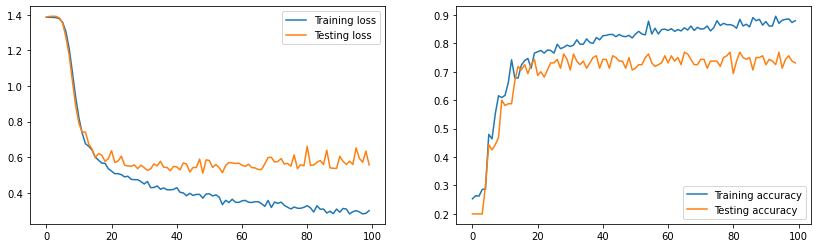

In [172]:
# plotting accuracies and losses
plt.figure(figsize=(14, 4))

# plotting loss
plt.subplot(1, 2, 1)
plt.plot(model_cnn_cont_fitted.history['loss'])
plt.plot(model_cnn_cont_fitted.history['val_loss'])
plt.legend(['Training loss','Testing loss'])

# plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(model_cnn_cont_fitted.history['accuracy'])
plt.plot(model_cnn_cont_fitted.history['val_accuracy'])
plt.legend(['Training accuracy','Testing accuracy'])

plt.show()

In [173]:
# creating checkpoint
checkpoint = ModelCheckpoint('weights_cont.hdf5', monitor = 'val_loss', save_best_only = True)
cnn_checkpoint =[checkpoint]

# refitting model with retained weights
model_cnn_cont_refitted = model_cnn_cont.fit(X_train_contset, y_train_contset, validation_split = 0.2,
                                             epochs = 100, batch_size = 32, callbacks= cnn_checkpoint, verbose = 0)

In [174]:
# load stored weights
model_cnn_cont.load_weights('weights_cont.hdf5')

# checking metrics
loss, accuracy = model_cnn_cont.evaluate(X_test_contset, y_test_contset, verbose=0)
print('Loss: ', loss,'\nAcc: ', accuracy)

Loss:  0.48399603366851807 
Acc:  0.7900000214576721


In [176]:
# collecting results for analysis

# empty dataframe
cnn_models_results = pd.DataFrame(columns=['Model', 'Train Score', 'Best parameters', 'Model Loss', 'Model Accuracy'])

# assining model results to lists
cnn_org_result = ['model_cnn_org', "%.2f" % round(org_search_results.best_score_, 2),
                  org_search_results.best_params_, 1.2, 0.75]

cnn_sob_result = ['model_cnn_sob', "%.2f" % round(sob_search_results.best_score_, 2),
                  sob_search_results.best_params_, 0.56, 0.79]

cnn_cont_result = ['model_cnn_cont', "%.2f" % round(cont_search_results.best_score_, 2), 
                   cont_search_results.best_params_, 0.48, 0.79]

# converting lists to series to append dataframe
cnn_org_result = pd.Series(cnn_org_result, index=cnn_models_results.columns)
cnn_sob_result = pd.Series(cnn_sob_result, index=cnn_models_results.columns)
cnn_cont_result = pd.Series(cnn_cont_result, index=cnn_models_results.columns)

# appending results to dataframe
cnn_models_results = cnn_models_results.append(cnn_org_result,ignore_index=True)
cnn_models_results = cnn_models_results.append(cnn_sob_result,ignore_index=True)
cnn_models_results = cnn_models_results.append(cnn_cont_result,ignore_index=True)

# view results
cnn_models_results.set_index('Model', inplace=True)
cnn_models_results

,Train Score,Best parameters,Model Loss,Model Accuracy
Model,,,,
model_cnn_org,0.81,"{'learning_rate': 0.001, 'epochs': 50, 'batch_...",1.20,0.75
model_cnn_sob,0.64,"{'learning_rate': 0.001, 'epochs': 100, 'batch...",0.56,0.79
model_cnn_cont,0.77,"{'learning_rate': 0.001, 'epochs': 100, 'batch...",0.48,0.79


#### 3.2.4. Section analysis<a id="19"></a>

Overall, all models have an average performance in the higher 70%. The model, in its current architecture and slightly unstable learning curves aside, performs best on the contrast dataset with minimal loss and the best accuracy. The difference in train and test scores on this set is also close meaning the model is well fitted.

## IV. Discussion<a id="20"></a>

The results of each model have been discussed in their respective sections and we will now address improvement.

**Dataset**

The main critique is on the original dataset used from Kaggle. The images are GAN generated and we cannot determine whether the models would be able to classify real images as trained in this exercise. In addition, for the CNN models we cannot determine whether they are correctly classifying the images or if they are picking up the aging algorithm used by the GAN's author.

**SVC models**

Having determined the best top parameters are for the linear kernel in almost every model we could run another grid search using a range of penalty parameters instead of predetermined values as we have above.

We have also noticed that these models performed better across all classes on the contrast dataset. Further processing could be done using the adaptive histogram enhancement as well as other filters such as gabor for wrinkle classification between under and over 25's (Skimage.filters.gabor, 2021).

**CNN models**

Although the overfitting was handled using a model callback, the learning curves were unstable. Batch normalization layers could be added to the model architecture to stabilize and increase learning.

In addition, due to computational restrictions only the Adam optimizer was used in the parameter search as we traded off generalization for convergence speed. In this case the SGD optimizer may perform better (Synced, 2019).

Another approach could be made as we have done with the SVC models, namely using binary crossentropy when compiling the model and essentially performing multiple binary classifications. However this approach is theoretical and may not generalize well.

## References<a id="21"></a>

Moreno-Garcia, C., 2021. *CMM536_Coursework_ModelSolution*. [online tutorial]. CMM536 Advanced Data Science. Robert Gordon University. School of Computing. 17 Feb 2021. Available from: http://campusmoodle.rgu.ac.uk/pluginfile.php/5397579/mod_resource/content/3/CMM536_Coursework_ModelSolution.html [Accessed 23.04.2021].

Scikit-image, 2021. *Skimage.filters.gabor*. Scikit-image community. Available from: https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gabor [Accessed 23.04.2021].

Scikit-image, 2021. *Skimage.filters.sobel*. Scikit-image community. Available from: https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel [Accessed 23.04.2021].

Scikit-image, 2021. *Skimage.exposure.equalize_adapthist* Scikit-image community. Available from: https://scikit-image.org/docs/dev/api/skimage.exposure.html?highlight=exposure%20equalize_adapthist#skimage.exposure.equalize_adapthist [Accessed 23.04.2021].

Scikit-learn, 2021. *SVM Mathematical Formulation* Scikit-learn community. Available from: https://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation [Accessed 23.04.2021].

Scikit-learn, 2021. *Sklearn.model_selection.GridSearchCV* Scikit-learn community. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV [Accessed 23.04.2021].

Scikit-learn, 2021. *Sklearn.metrics.recall_score* Scikit-learn community. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score [Accessed 23.04.2021].

Scikit-learn, 2021. *Sklearn.model_selection.StratifiedKFold* Scikit-learn community. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold [Accessed 23.04.2021].

Scikit-learn, 2021. *Sklearn.metrics.classification_report* Scikit-learn community. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold [Accessed 23.04.2021].

Keras, 2021. *Adam* Keras community. Available from: https://keras.io/api/optimizers/adam/ [Accessed 23.04.2021].

Keras, 2021. *CategoricalCrossentropy class* Keras community. Available from: https://keras.io/api/metrics/probabilistic_metrics/#categoricalcrossentropy-class [Accessed 23.04.2021].

Keras, 2021. *Softmax function* Keras community. Available from: https://keras.io/api/layers/activations/ [Accessed 23.04.2021].

Keras, 2021. *Accuracy class* Keras community. Available from: https://keras.io/api/metrics/accuracy_metrics/#accuracy-class [Accessed 23.04.2021].

Scikit-learn, 2021. *Sklearn.model_selection.RandomizedSearchCV* Scikit-learn community. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html?highlight=randomized%20search#sklearn.model_selection.RandomizedSearchCV [Accessed 23.04.2021].

Tensorflow, 2021. *Tf.keras.wrappers.scikit_learn.KerasClassifier* Tensorflow community. Available from: https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier [Accessed 23.04.2021].

Brownlee, J. 2016. *Use Keras Deep Learning Models with Scikit-Learn in Python* [online]. Machine Learning Mastery. Available from: https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/ [Accessed 23.04.2021].

Esteban, M. 2021. *Introduction to Deep Learning with Keras* [online course]. DataCamp. Available from: https://learn.datacamp.com/courses/introduction-to-deep-learning-with-keras [Accessed 23.04.2021].

Synced, 2019. *ICLR 2019 | ‘Fast as Adam & Good as SGD’ – New Optimizer Has Both*. [online]. Medium. Available from: https://medium.com/syncedreview/iclr-2019-fast-as-adam-good-as-sgd-new-optimizer-has-both-78e37e8f9a34 [Accessed 23.04.2021].